In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import plotly.express as px

In [14]:
# Load pre-cleaned datasets from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set your folder path
folder = "/content/drive/MyDrive/Projects/tourism_revenue_political_stability_analysis"

# Load datasets
files_info = {
    'gdp_ppp.csv': 'gdp_ppp',
    'household_consumption.csv': 'household_consumption',
    'tourism_receipts.csv': 'tourism_receipts',
    'inflation.csv': 'inflation',
    'exchange_rate.csv': 'exchange_rate',
    'unemployment.csv': 'unemployment',
    'fdi.csv': 'fdi',
    'political_stability.csv': 'political_stability',
    'tourism_arrivals.csv': 'tourism_arrivals'
}

# Convert all to long format and merge
long_dfs = []
for filename, value_name in files_info.items():
    df = pd.read_csv(f"{folder}/{filename}", skiprows=4, engine='python', on_bad_lines='skip')
    df_long = df.melt(id_vars='Country Name', var_name='year', value_name=value_name)
    df_long.rename(columns={'Country Name': 'countryname'}, inplace=True)
    df_long = df_long[df_long['year'].str.isnumeric()].copy()
    df_long['year'] = df_long['year'].astype(int) + 1955
    long_dfs.append(df_long)

# Merge all long-format DataFrames
from functools import reduce
df = reduce(lambda left, right: pd.merge(left, right, on=['countryname', 'year'], how='inner'), long_dfs)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Rescale variables
df['gdp_ppp'] /= 1e12
df['household_consumption'] /= 1e12
df['tourism_receipts'] /= 1e9
df['tourism_arrivals'] /= 1e6

# Create interaction term
df['interaction'] = df['political_stability'] * df['household_consumption']

# Drop rows with missing critical variables
df = df.dropna(subset=[
    'tourism_receipts', 'household_consumption', 'political_stability',
    'gdp_ppp', 'inflation', 'exchange_rate', 'unemployment', 'fdi'
])

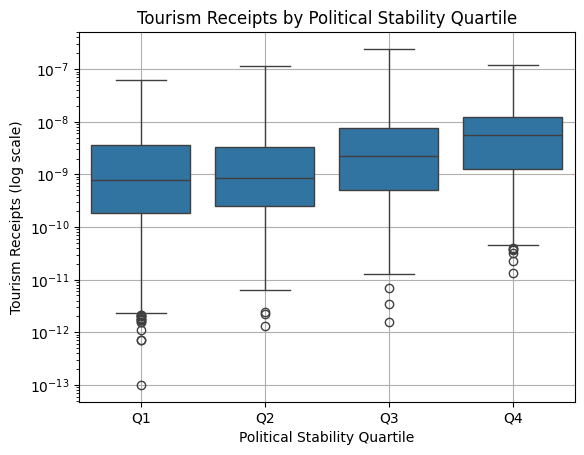

In [23]:
# Scale the Y-axis to log scale
plt.yscale('log')

# Create political stability quartiles (Q1 = lowest stability)
df['stability_quartile'] = pd.qcut(df['political_stability'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Boxplot of tourism receipts by political stability quartile
sns.boxplot(data=df, x='stability_quartile', y='tourism_receipts')
plt.yscale('log')
plt.title("Tourism Receipts by Political Stability Quartile")
plt.xlabel("Political Stability Quartile")
plt.ylabel("Tourism Receipts (log scale)")
plt.grid(True)
plt.show()

In [25]:
# Check and fix data types
df['tourism_receipts'] = pd.to_numeric(df['tourism_receipts'], errors='coerce')
df['tourism_arrivals'] = pd.to_numeric(df['tourism_arrivals'], errors='coerce')

numeric_vars = [
    'political_stability', 'household_consumption', 'gdp_ppp',
    'inflation', 'exchange_rate', 'unemployment', 'fdi'
]
for var in numeric_vars:
    df[var] = pd.to_numeric(df[var], errors='coerce')

# Regression: Base model
model1 = smf.ols(
    "tourism_receipts ~ political_stability + household_consumption + gdp_ppp + inflation + exchange_rate + unemployment + fdi",
    data=df
).fit()
print(model1.summary())

# Regression: With interaction term
model2 = smf.ols(
    "tourism_receipts ~ political_stability * household_consumption + gdp_ppp + inflation + exchange_rate + unemployment + fdi",
    data=df
).fit()
print(model2.summary())

# Regression: Using arrivals instead of receipts
# Ensure arrivals is also non-missing for this regression
df_arrivals = df.dropna(subset=["tourism_arrivals"])
model3 = smf.ols(
    "tourism_arrivals ~ political_stability * household_consumption + gdp_ppp + inflation + exchange_rate + unemployment + fdi",
    data=df_arrivals
).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:       tourism_receipts   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     16.63
Date:                Thu, 08 May 2025   Prob (F-statistic):           3.49e-16
Time:                        00:13:09   Log-Likelihood:                 40257.
No. Observations:                2454   AIC:                        -8.050e+04
Df Residuals:                    2448   BIC:                        -8.047e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              9.522e-